In [1]:
import sys
import json
import glob
import itertools
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# 1. Add parent directory (parametric_qst) to path to find 'model' and 'data_handling' folders
sys.path.append(str(Path("..").resolve()))

from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# 2. Import your new modularized code
from model import ConditionalRBM, train_loop, get_sigmoid_curve

# Define paths (These are local to tfim_4x4_mod folder)
data_dir = Path("measurements")
state_dir = Path("state_vectors")
exp_dir = Path("experiments")
exp_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Loading data from: {data_dir.resolve()}")

Running on: cpu
Loading data from: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_4x4_mod/measurements


In [2]:
def generate_all_states(num_qubits: int, device: torch.device):
    """Generates all 2^N basis states for exact overlap calculation."""
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    """Computes overlap between RBM wavefunction and Ground Truth."""
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true)

    # Prepare condition
    cond = torch.tensor([h_val], device=device, dtype=torch.float32)

    # Use the method from the module
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [4]:
GEN_SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
N_EPOCHS = 50

# --- CONFIGURATION ---
SAMPLE_SIZES = [2_000, 5_000, 20_000]

# Training and Eval sets
h_train_support = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
h_eval_novel   = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
all_h_eval     = sorted(list(set(h_train_support + h_eval_novel)))

# Construct file paths
file_names = [f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_train_support]
file_paths = [data_dir / fn for fn in file_names]

# Verify files exist
file_paths = [fp for fp in file_paths if fp.exists()]

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

print(f"Starting Experiment Loop: {SAMPLE_SIZES}")

for n_samples in SAMPLE_SIZES:
    print(f"\n>>> RUNNING: {n_samples} samples per support point <<<")

    # 1. Dataset
    ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples]*len(file_paths))
    loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)

    # 2. Model (Imported from module)
    model = ConditionalRBM(
        num_visible=ds.num_qubits,
        num_hidden=64,
        cond_dim=1,
        conditioner_width=64,
        k=10
    ).to(device)

    # Initialization
    current_std = 0.05
    model.initialize_weights(std=current_std)
    print(f"Model initialized with std={current_std}")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # Scheduler (Imported from module)
    scheduler = get_sigmoid_curve(1e-2, 1e-4, N_EPOCHS*len(loader), 0.005)

    # 3. Train (Imported from module)
    model = train_loop(
        model,
        optimizer,
        loader,
        num_epochs=N_EPOCHS,
        lr_schedule_fn=scheduler,
        noise_frac=0.1,
        rng=rng
    )

    # 4. Evaluation (Uses local compute_overlap)
    print("Evaluating...")
    all_states = generate_all_states(GEN_SIDE_LENGTH**2, device)
    results = []

    for h_val in all_h_eval:
        gt_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
        if not gt_path.exists(): continue

        ov = compute_overlap(model, h_val, gt_path, all_states)

        rtype = "support" if h_val in h_train_support else "novel"
        results.append({"h": h_val, "overlap": ov, "type": rtype})

    # 5. Save Report
    run_id = f"streamlined_{n_samples}"
    report_config = {"n_samples": n_samples, "epochs": N_EPOCHS, "std": current_std}

    with open(exp_dir / f"{run_id}_report.json", "w") as f:
        json.dump({"config": report_config, "results": results}, f, indent=2)

    print(f"Run {run_id} complete.")

print("\nAll experiments finished.")

Starting Experiment Loop: [2000, 5000, 20000]

>>> RUNNING: 2000 samples per support point <<<
Model initialized with std=0.05
Epoch  | Loss       | LR        
-----------------------------------
1      | -0.0831     | 0.008451
10     | +0.0104     | 0.007443
20     | -0.0329     | 0.005920
30     | +0.0159     | 0.004204
40     | -0.0008     | 0.002676
50     | -0.0194     | 0.001572
Evaluating...
Run streamlined_2000 complete.

>>> RUNNING: 5000 samples per support point <<<
Model initialized with std=0.05
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0544     | 0.009854
10     | +0.0196     | 0.009334
20     | +0.0019     | 0.007098
30     | +0.0164     | 0.003023
40     | -0.0106     | 0.000772
50     | -0.0022     | 0.000224
Evaluating...
Run streamlined_5000 complete.

>>> RUNNING: 20000 samples per support point <<<
Model initialized with std=0.05
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0305     | 0.0100

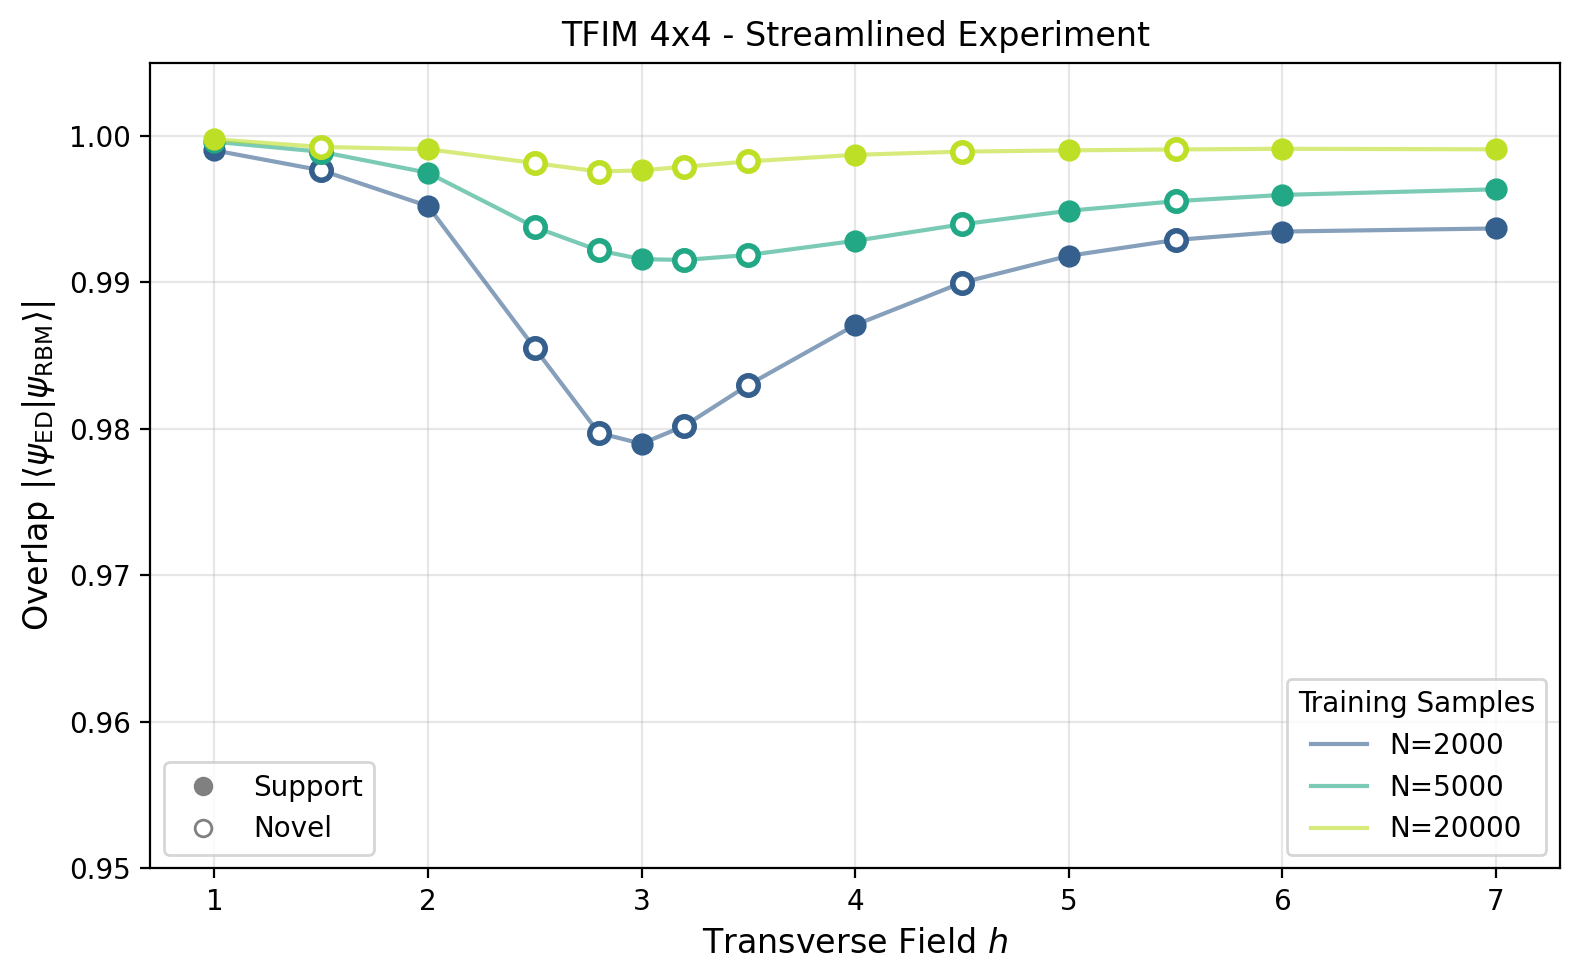

In [5]:
# Load all reports
report_files = sorted(glob.glob(str(exp_dir / "*_report.json")))
experiments = []
for fpath in report_files:
    with open(fpath, "r") as f: experiments.append(json.load(f))

# Sort by sample size
experiments.sort(key=lambda x: x["config"]["n_samples"])

plt.figure(figsize=(8, 5), dpi=200)
colors = cm.viridis(np.linspace(0.3, 0.9, len(experiments)))

for i, exp in enumerate(experiments):
    n = exp["config"]["n_samples"]
    df = pd.DataFrame(exp["results"]).sort_values("h")

    supp = df[df["type"] == "support"]
    nov  = df[df["type"] == "novel"]

    c = colors[i]
    if len(experiments) == 1: c = 'tab:blue'

    # Line
    plt.plot(df["h"], df["overlap"], '-', color=c, alpha=0.6, label=f"N={n}")
    # Support
    plt.plot(supp["h"], supp["overlap"], 'o', color=c, markersize=7)
    # Novel
    plt.plot(nov["h"], nov["overlap"], 'o', color=c, markerfacecolor='white', markeredgewidth=2, markersize=7)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_\mathrm{ED} | \psi_\mathrm{RBM} \rangle|$", fontsize=12)
plt.title(f"TFIM {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH} - Streamlined Experiment", fontsize=12)

# Legends
color_leg = plt.legend(loc='lower right', title="Training Samples")
plt.gca().add_artist(color_leg)

custom_lines = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', label='Support'),
    Line2D([0], [0], color='gray', marker='o', markerfacecolor='white', linestyle='None', label='Novel')
]
plt.legend(handles=custom_lines, loc='lower left')

plt.ylim(0.95, 1.005)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()